In [1]:
# package(s) related to time, space and id
import logging
import datetime, time
import platform
import itertools
# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt

# OpenTNSim
import opentnsim

# Used for mathematical functions
import math             
import tqdm
# Used for making the graph to visualize our problem
import networkx as nx   

import plotly.express as px
from plotly.subplots import make_subplots

#logging.basicConfig(level=logging.DEBUG) #turn on all the debug messages
logging.basicConfig(level=logging.INFO)# turn off all the debug messages


### Create graph with navigation information

In [2]:
# specify a number of coordinate along your route (coords are: lon, lat)
coords = [
    [0,0],
    [0.4042418779,0],
    [0.79950060287,0], 
    [1.10492779947,0],
    [1.25764139777,0],
    [1.27560770345,0],
    [1.527135983,0],
    [1.69781588699,0], 
    [2.03019254211,0],
    [2.16493983473,0],
    [2.34460289155,0],
    [3.0093562018,0],
    [3.27885078704,0], 
    [3.36868231545,0],
    [4.06038508422,0],
    [4.06936823706,0], 
    [4.4915764206,0],
    [4.54547533765,0],
    [4.68022263026,0], 
    [5.04853189675,0],
    [5.2102286479,0],
    [5.68633574848,0],
    [6.1354933906,0],
    [6.5846510326,0], 
] 


# for each edge (between above coordinates) specify the depth (m)
depths = [
            7.5, 4.18, 4.18, 7.83,7.83, 
            7.5, 6.5, 10.6, 6.45, 8.04,
            8.04, 5.65, 8.87, 8.87, 4.93,
            4.93, 7.7,7.7, 9.8, 5.45, 5.45,5.45, 5.45
         ] # [m]

current_speeds = [
                    -2.24* 0.2777, -3.4* 0.2777, -4.93* 0.2777, -2.59* 0.2777, -2.59* 0.2777,
                    -3.26* 0.2777, -3.85* 0.2777, -1.87* 0.2777, -1.08* 0.2777, -2.83* 0.2777, 
                    -2.83* 0.2777, -4.99* 0.2777,  -2.89* 0.2777,  -2.89* 0.2777, -6.4* 0.2777,
                    -6.4* 0.2777, -3.42* 0.2777, -3.42* 0.2777, -1.64* 0.2777, -4.1* 0.2777, -4.1* 0.2777,-4.1* 0.2777, -4.1* 0.2777
                ]  # [m/s]

V_g_profile_up = [
                    3.33, 3.33, 3.33, 3.33, 3.33,   
                    3.33, 3.33, 3.33, 3.33, 3.33,
                    3.33, 3.33, 3.33, 3.33, 3.33,
                    3.33, 3.33, 3.33, 3.33, 3.33, 3.33, 3.33, 3.33
                ] # [m/s] for upstream, 3.33 m/s = 12 km/h

V_g_profile_down = [
                     4.44, 4.44, 4.44, 4.44, 4.44, 
                     4.44, 4.44, 4.44, 4.44, 4.44, 
                     4.44, 4.44, 4.44, 4.44, 4.44, 
                     4.44, 4.44, 4.44, 3.33, 4.44, 4.44, 4.44, 4.44
                    ] # [m/s] for downstream, 4.44 m/s = 16 km/h


# check of nr of coords and nr of depths align
assert len(coords) == len(depths) + 1, 'nr of depths does not correspond to nr of coords'

In [3]:
# create a graph based on coords and depths
FG = nx.DiGraph()
nodes = []
path = []

# add nodes
Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Locatable), {})

for index, coord in enumerate(coords):
    data_node = {"name": "Node " + str(index), "geometry": shapely.geometry.Point(coord[0], coord[1])}
    nodes.append(Node(**data_node))
    
positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)

# add edges
path = [[nodes[i], nodes[i+1]] for i in range(len(nodes)-1)]

for index, edge in enumerate(path):
    # For the energy consumption calculation we add info to the graph. We need depth info for resistance.
    # NB: the CalculateEnergy routine expects the graph to have "Info" that contains "GeneralDepth" 
    #     this may not be very generic!
    FG.add_edge(edge[0].name, edge[1].name, weight = 1, Info = {
        "GeneralDepth": depths[index],
        "CurrentSpeed": current_speeds[index],
        "VesselSpeedToGroundProfile_upstream": V_g_profile_up[index],
        "VesselSpeedToGroundProfile_downstream": V_g_profile_down[index]
    })

# toggle to undirected and back to directed to make sure all edges are two way traffic
FG = FG.to_undirected() 
FG = FG.to_directed() 

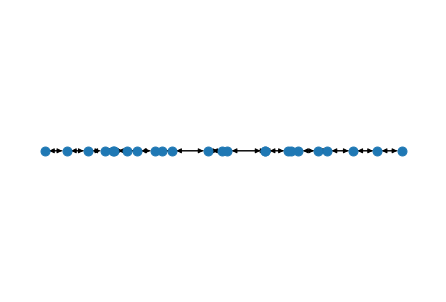

In [4]:
# show graph
nx.draw(FG, positions, node_size=80)

plt.show()

### Define the path on the graph for energy use simulation

In [5]:
path_up_1_Budapest2Regensburg = nx.dijkstra_path(FG, nodes[23].name, nodes[0].name)

### Create vessel sailing on path - add VesselProperties and ConsumesEnergy mixins

In [6]:
# Make your preferred class out of available mix-ins.
TransportResource = type(
    "Vessel",
    (
        opentnsim.core.Identifiable,
        opentnsim.core.Movable,
        opentnsim.core.VesselProperties,  # needed to add vessel properties
        opentnsim.energy.ConsumesEnergy,
        opentnsim.core.ExtraMetadata,
    ),
    {},
)  # needed to calculate resistances

vessels sailing on path include 17 vessel types sailing upstream loaded and ballast

In [7]:
# Create a dict with all important settings

data_vessel_MCV135_up_loaded_MHWL = {
    "env": None,
    "name": 'MCV135_up_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 135,
    "T": 2.5,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1800,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [8]:
# Create a dict with all important settings

data_vessel_MCV135_up_ballast = {
    "env": None,
    "name": 'MCV135_up_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 135,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1800,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [9]:
# Create a dict with all important settings

data_vessel_MCV110_up_loaded_MHWL = {
    "env": None,
    "name": 'MCV110_up_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 110,
    "T": 2.5,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1150,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [10]:
# Create a dict with all important settings

data_vessel_MCV110_up_ballast = {
    "env": None,
    "name": 'MCV110_up_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 110,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1150,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [11]:
# Create a dict with all important settings

data_vessel_MCV110_1B_up_loaded_MHWL = {
    "env": None,
    "name": 'MCV110_1B_up_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 186.5,
    "T": 2.5,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1150,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [12]:
# Create a dict with all important settings

data_vessel_MCV110_1B_up_ballast = {
    "env": None,
    "name": 'MCV110_1B_up_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 186.5,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1150,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [13]:
# Create a dict with all important settings

data_vessel_MCV105_up_loaded_MHWL = {
    "env": None,
    "name": 'MCV105_up_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 105,
    "T": 2.5,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":950,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [14]:
# Create a dict with all important settings

data_vessel_MCV105_up_ballast = {
    "env": None,
    "name": 'MCV105_up_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 105,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 950,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [15]:
# Create a dict with all important settings

data_vessel_MCV95_up_loaded_MHWL = {
    "env": None,
    "name": 'MCV95_up_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11,
    "L": 95,
    "T": 2,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1300,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [16]:
# Create a dict with all important settings

data_vessel_MCV95_up_ballast = {
    "env": None,
    "name": 'MCV95_up_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11,
    "L": 95,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1300,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [17]:
# Create a dict with all important settings

data_vessel_MCV85_9_5_up_loaded_MHWL = {
    "env": None,
    "name": 'MCV85_9_5_up_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 9.5,
    "L": 85,
    "T": 2,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":750,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [18]:
# Create a dict with all important settings

data_vessel_MCV85_9_5_up_ballast = {
    "env": None,
    "name": 'MCV85_9_5_up_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 9.5,
    "L": 85,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 750,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [19]:
# Create a dict with all important settings

data_vessel_MCV85_9_5_1B_up_loaded_MHWL = {
    "env": None,
    "name": 'MCV135_up_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 9.5,
    "L": 161.5,
    "T": 2,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":750,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [20]:
# Create a dict with all important settings

data_vessel_MCV85_9_5_1B_up_ballast = {
    "env": None,
    "name": 'MCV135_up_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 9.5,
    "L": 161.5,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 750,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [21]:
# Create a dict with all important settings

data_vessel_MCV85_8_2_up_loaded_MHWL = {
    "env": None,
    "name": 'MCV85_8_2_up_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 8.2,
    "L": 85,
    "T": 2,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":600,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [22]:
# Create a dict with all important settings

data_vessel_MCV85_8_2_up_ballast = {
    "env": None,
    "name": 'MCV85_8_2_up_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 8.2,
    "L": 85,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 600,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [23]:
# Create a dict with all important settings

data_vessel_MCV80_8_2_up_loaded_MHWL = {
    "env": None,
    "name": 'MCV80_8_2_up_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 8.2,
    "L": 80,
    "T": 2,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":600,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [24]:
# Create a dict with all important settings

data_vessel_MCV80_8_2_up_ballast = {
    "env": None,
    "name": 'MCV80_8_2_up_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 8.2,
    "L": 80,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 600,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [25]:
# Create a dict with all important settings

data_vessel_MTV110_up_loaded_MHWL = {
    "env": None,
    "name": 'MTV110_up_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 110,
    "T": 2.5,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1150,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [26]:
# Create a dict with all important settings

data_vessel_MTV110_up_ballast = {
    "env": None,
    "name": 'MTV110_up_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 110,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1150,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [27]:
# Create a dict with all important settings

data_vessel_MTV110_1B_up_loaded_MHWL = {
    "env": None,
    "name": 'MTV110_1B_up_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 186.5,
    "T": 2.5,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1150,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [28]:
# Create a dict with all important settings

data_vessel_MTV110_1B_up_ballast = {
    "env": None,
    "name": 'MTV110_1B_up_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 186.5,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1150,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [29]:
# Create a dict with all important settings

data_vessel_MTV85_up_loaded_MHWL = {
    "env": None,
    "name": 'MTV85_up_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 9.5,
    "L": 85,
    "T": 2,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":750,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [30]:
# Create a dict with all important settings

data_vessel_MTV85_up_ballast = {
    "env": None,
    "name": 'MTV85_up_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 9.5,
    "L": 85,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 750,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [31]:
# Create a dict with all important settings

data_vessel_PUSH23_1B_up_loaded_MHWL = {
    "env": None,
    "name": 'PUSH23_1B_up_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 99.5,
    "T": 2.5,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1000,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [32]:
# Create a dict with all important settings

data_vessel_PUSH23_1B_up_ballast = {
    "env": None,
    "name": 'PUSH23_1B_up_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 99.5,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1000,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [33]:
# Create a dict with all important settings

data_vessel_PUSH23_2B_up_loaded_MHWL = {
    "env": None,
    "name": 'PUSH23_2B_up_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 176,
    "T": 2.5,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1000,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [34]:
# Create a dict with all important settings

data_vessel_PUSH23_2B_up_ballast = {
    "env": None,
    "name": 'PUSH23_2B_up_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 176,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1000,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [35]:
# Create a dict with all important settings

data_vessel_PUSH35_2B_up_loaded_MHWL = {
    "env": None,
    "name": 'PUSH35_2B_up_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 188,
    "T": 2.5,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1700,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [36]:
# Create a dict with all important settings

data_vessel_PUSH35_2B_up_ballast = {
    "env": None,
    "name": 'PUSH35_2B_up_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 188,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1700,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [37]:
# Create a dict with all important settings

data_vessel_PUSH35_4B_up_loaded_MHWL = {
    "env": None,
    "name": 'PUSH35_4B_up_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 22.9,
    "L": 188,
    "T": 2.5,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":2500,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [38]:
# Create a dict with all important settings

data_vessel_PUSH35_4B_up_ballast = {
    "env": None,
    "name": 'PUSH35_4B_up_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 22.9,
    "L": 188,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 2500,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [39]:
# Create a dict with all important settings

data_vessel_PUSH57_2B_up_loaded_MHWL = {
    "env": None,
    "name": 'PUSH57_2B_up_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 210,
    "T": 2.5,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1470,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [40]:
# Create a dict with all important settings

data_vessel_PUSH57_2B_up_ballast = {
    "env": None,
    "name": 'PUSH57_2B_up_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 210,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1470,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



### Define simulation

define basic simulation for vessel moving and consuming energy

In [41]:
def run_simulation(path,**data_vessel):
    
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())

    # Add graph to environment
    env.FG = FG

    # Add environment and path to the vessel
    # create a fresh instance of vessel
    vessel = TransportResource(**data_vessel)
    vessel.env = env                                        #the created environment
    vessel.name = 'Vessel No.1'                     
    vessel.route = path                                     #the route (the sequence of nodes, as stored as the second column in the path)
    vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)
    # vessel.V_g_ave = V_g_ave
    # vessel.sailing_upstream = sailing_upstream
    # vessel.P_tot_given = P_tot_given
    # Start the simulation
    env.process(vessel.move())
    env.run()
    
    return vessel

define specific vessel simulation with vessel type and number of trips

In [42]:
def get_energy(nr_trips, path,**data_vessel):
    vessel = run_simulation(path,**data_vessel)
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel=vessel)
    energycalculation.calculate_energy_consumption()
    
    df = pd.DataFrame.from_dict(energycalculation.energy_use)
    
    # selected = ['edge_start','edge_stop','distance','total_energy','total_H2_350bar_PEMFC_mass','total_H2_350bar_PEMFC_40ft_containers']
    # df_energy = df[selected]
    # df_energy['distance_km_cum']=df_energy['distance'].cumsum()/1000
    # df_energy['total_trips_energy'] = df_energy['total_energy']*nr_trips
    # df_energy['total_trips_H2_350bar_PEMFC_mass_ton'] = df_energy['total_H2_350bar_PEMFC_mass']*nr_trips/1000000
    # df_energy['total_trips_H2_350bar_PEMFC_40ft_containers'] = df_energy['total_H2_350bar_PEMFC_40ft_containers']*nr_trips
    # df_energy['energy_consumption_kWh_cum'] = df_energy['total_energy'].cumsum()
    # df_energy['total_H2_350bar_PEMFC_mass_cum_ton'] = df_energy['total_H2_350bar_PEMFC_mass'].cumsum()/1000000
    # df_energy['total_H2_350bar_PEMFC_40ft_containers_cum'] = df_energy['total_H2_350bar_PEMFC_40ft_containers'].cumsum()
    # df_energy['total_trips_H2_350bar_PEMFC_mass_cum_ton'] = df_energy['total_trips_H2_350bar_PEMFC_mass_ton'].cumsum()
    # df_energy['total_trips_H2_350bar_PEMFC_40ft_containers_cum'] = df_energy['total_trips_H2_350bar_PEMFC_40ft_containers'].cumsum()
    selected = ['distance','total_H2_500bar_PEMFC_mass','total_H2_500bar_PEMFC_40ft_containers']
    df_energy = df[selected]
    df_energy['distance_km']= df_energy['distance']/1000
    df_energy['distance_km_cum']=df_energy['distance_km'].cumsum()
    # df_energy['total_trips_energy'] = df_energy['total_energy']*nr_trips
    df_energy['total_trips_H2_500bar_PEMFC_mass_ton'] = df_energy['total_H2_500bar_PEMFC_mass']*nr_trips/1000000
    df_energy['total_trips_H2_500bar_PEMFC_40ft_containers'] = df_energy['total_H2_500bar_PEMFC_40ft_containers']*nr_trips
    # df_energy['energy_consumption_kWh_cum'] = df_energy['total_energy'].cumsum()
    # df_energy['total_H2_350bar_PEMFC_mass_cum_ton'] = df_energy['total_H2_350bar_PEMFC_mass'].cumsum()/1000000
    # df_energy['total_H2_500bar_PEMFC_40ft_containers_cum'] = df_energy['total_H2_500bar_PEMFC_40ft_containers'].cumsum()
    # df_energy['total_trips_H2_350bar_PEMFC_mass_cum_ton'] = df_energy['total_trips_H2_350bar_PEMFC_mass_ton'].cumsum()
    # df_energy['total_trips_H2_350bar_PEMFC_40ft_containers_cum'] = df_energy['total_trips_H2_350bar_PEMFC_40ft_containers'].cumsum()
    selection= ['distance_km', 'distance_km_cum','total_trips_H2_500bar_PEMFC_mass_ton','total_trips_H2_500bar_PEMFC_40ft_containers']
    df_energy = df_energy[selection]
    
    return df_energy

In [43]:
energy_MCV135_up_loaded_MHWL_path = get_energy(17,path_up_1_Budapest2Regensburg,**data_vessel_MCV135_up_loaded_MHWL)
# pd.options.display.max_columns = None
# energy_MCV135_up_loaded_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,50.0,50.0,3.770896,3.861644
1,50.0,100.0,3.770896,3.861644
2,53.0,153.0,3.997150,4.093343
3,18.0,171.0,1.357522,1.390192
4,41.0,212.0,1.393664,1.427204
5,15.0,227.0,0.800188,0.819445
6,6.0,233.0,0.320075,0.327778
7,47.0,280.0,8.749507,8.960068
8,1.0,281.0,0.186160,0.190640
9,77.0,358.0,3.465701,3.549105


In [44]:
energy_MCV135_up_ballast_MHWL_path = get_energy(2,path_up_1_Budapest2Regensburg,**data_vessel_MCV135_up_ballast)
# pd.options.display.max_columns = None
# energy_MCV135_up_ballast_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,50.0,50.0,0.599702,0.614134
1,50.0,100.0,0.599702,0.614134
2,53.0,153.0,0.635684,0.650982
3,18.0,171.0,0.215893,0.221088
4,41.0,212.0,0.222176,0.227522
5,15.0,227.0,0.134309,0.137541
6,6.0,233.0,0.053724,0.055016
7,47.0,280.0,1.177354,1.205687
8,1.0,281.0,0.025050,0.025653
9,77.0,358.0,0.583988,0.598042


In [45]:
energy_MCV110_up_loaded_MHWL_path = get_energy(87,path_up_1_Budapest2Regensburg,**data_vessel_MCV110_up_loaded_MHWL)
# pd.options.display.max_columns = None
# energy_MCV110_up_loaded_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,50.0,50.0,17.217588,17.631939
1,50.0,100.0,17.217588,17.631939
2,53.0,153.0,18.250643,18.689855
3,18.0,171.0,6.198332,6.347498
4,41.0,212.0,6.187963,6.336880
5,15.0,227.0,3.634093,3.721550
6,6.0,233.0,1.453637,1.488620
7,47.0,280.0,32.720617,33.508056
8,1.0,281.0,0.696183,0.712937
9,77.0,358.0,15.529204,15.902922


In [46]:
energy_MCV110_up_ballast_MHWL_path = get_energy(7,path_up_1_Budapest2Regensburg,**data_vessel_MCV110_up_ballast)
# pd.options.display.max_columns = None
# energy_MCV110_up_ballast_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,50.0,50.0,1.363653,1.396470
1,50.0,100.0,1.363653,1.396470
2,53.0,153.0,1.445472,1.480258
3,18.0,171.0,0.490915,0.502729
4,41.0,212.0,0.503116,0.515224
5,15.0,227.0,0.301415,0.308669
6,6.0,233.0,0.120566,0.123468
7,47.0,280.0,2.632693,2.696050
8,1.0,281.0,0.056015,0.057363
9,77.0,358.0,1.313096,1.344696


In [47]:
energy_MCV110_1B_up_loaded_MHWL_path = get_energy(82,path_up_1_Budapest2Regensburg,**data_vessel_MCV110_1B_up_loaded_MHWL)
# pd.options.display.max_columns = None
# energy_MCV110_1B_up_loaded_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,50.0,50.0,32.766306,33.554845
1,50.0,100.0,32.766306,33.554845
2,53.0,153.0,34.732285,35.568136
3,18.0,171.0,11.795870,12.079744
4,41.0,212.0,10.650270,10.906575
5,15.0,227.0,6.756042,6.918630
6,6.0,233.0,2.702417,2.767452
7,47.0,280.0,30.840122,31.582306
8,1.0,281.0,0.656173,0.671964
9,77.0,358.0,27.980637,28.654006


In [48]:
energy_MCV110_1B_up_ballast_MHWL_path = get_energy(7,path_up_1_Budapest2Regensburg,**data_vessel_MCV110_1B_up_ballast)
# pd.options.display.max_columns = None
# energy_MCV110_1B_up_ballast_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,50.0,50.0,2.800738,2.868139
1,50.0,100.0,2.800738,2.868139
2,53.0,153.0,2.968782,3.040227
3,18.0,171.0,1.008266,1.032530
4,41.0,212.0,2.296605,2.351874
5,15.0,227.0,0.840221,0.860442
6,6.0,233.0,0.336089,0.344177
7,47.0,280.0,2.632693,2.696050
8,1.0,281.0,0.056015,0.057363
9,77.0,358.0,4.313136,4.416934


In [49]:
energy_MCV105_up_loaded_MHWL_path = get_energy(14,path_up_1_Budapest2Regensburg,**data_vessel_MCV105_up_loaded_MHWL)
# pd.options.display.max_columns = None
# energy_MCV105_up_loaded_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,50.0,50.0,2.683724,2.748310
1,50.0,100.0,2.683724,2.748310
2,53.0,153.0,2.844748,2.913208
3,18.0,171.0,0.966141,0.989391
4,41.0,212.0,0.983019,1.006676
5,15.0,227.0,0.566706,0.580345
6,6.0,233.0,0.226683,0.232138
7,47.0,280.0,4.349667,4.454344
8,1.0,281.0,0.092546,0.094773
9,77.0,358.0,2.512573,2.573039


In [50]:
energy_MCV105_up_ballast_MHWL_path = get_energy(2,path_up_1_Budapest2Regensburg,**data_vessel_MCV105_up_ballast)
# pd.options.display.max_columns = None
# energy_MCV105_up_ballast_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,50.0,50.0,0.366959,0.375790
1,50.0,100.0,0.366959,0.375790
2,53.0,153.0,0.388977,0.398338
3,18.0,171.0,0.132105,0.135285
4,41.0,212.0,0.137719,0.141033
5,15.0,227.0,0.080815,0.082760
6,6.0,233.0,0.032326,0.033104
7,47.0,280.0,0.621381,0.636335
8,1.0,281.0,0.013221,0.013539
9,77.0,358.0,0.361854,0.370563


In [51]:
energy_MCV95_up_loaded_MHWL_path = get_energy(4,path_up_1_Budapest2Regensburg,**data_vessel_MCV95_up_loaded_MHWL)
# pd.options.display.max_columns = None
# energy_MCV95_up_loaded_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,50.0,50.0,0.619966,0.634886
1,50.0,100.0,0.619966,0.634886
2,53.0,153.0,0.657164,0.672979
3,18.0,171.0,0.223188,0.228559
4,41.0,212.0,0.232977,0.238583
5,15.0,227.0,0.133201,0.136406
6,6.0,233.0,0.053280,0.054563
7,47.0,280.0,1.560558,1.598114
8,1.0,281.0,0.033203,0.034002
9,77.0,358.0,0.583536,0.597579


In [52]:
energy_MCV95_up_ballast_MHWL_path = get_energy(0,path_up_1_Budapest2Regensburg,**data_vessel_MCV95_up_ballast)
# pd.options.display.max_columns = None
# energy_MCV95_up_ballast_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,50.0,50.0,0.0,0.0
1,50.0,100.0,0.0,0.0
2,53.0,153.0,0.0,0.0
3,18.0,171.0,0.0,0.0
4,41.0,212.0,0.0,0.0
5,15.0,227.0,0.0,0.0
6,6.0,233.0,0.0,0.0
7,47.0,280.0,0.0,0.0
8,1.0,281.0,0.0,0.0
9,77.0,358.0,0.0,0.0


In [53]:
energy_MCV85_9_5_up_loaded_MHWL_path = get_energy(84,path_up_1_Budapest2Regensburg,**data_vessel_MCV85_9_5_up_loaded_MHWL)
# pd.options.display.max_columns = None
# energy_MCV85_9_5_up_loaded_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,50.0,50.0,11.066878,11.333209
1,50.0,100.0,11.066878,11.333209
2,53.0,153.0,11.730891,12.013201
3,18.0,171.0,3.984076,4.079955
4,41.0,212.0,4.074186,4.172233
5,15.0,227.0,2.372031,2.429116
6,6.0,233.0,0.948813,0.971646
7,47.0,280.0,20.603687,21.099526
8,1.0,281.0,0.438376,0.448926
9,77.0,358.0,10.398048,10.648282


In [54]:
energy_MCV85_9_5_up_ballast_MHWL_path = get_energy(7,path_up_1_Budapest2Regensburg,**data_vessel_MCV85_9_5_up_ballast)
# pd.options.display.max_columns = None
# energy_MCV85_9_5_up_ballast_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,50.0,50.0,0.867731,0.888613
1,50.0,100.0,0.867731,0.888613
2,53.0,153.0,0.919795,0.941930
3,18.0,171.0,0.312383,0.319901
4,41.0,212.0,0.330767,0.338727
5,15.0,227.0,0.193750,0.198413
6,6.0,233.0,0.077500,0.079365
7,47.0,280.0,1.716974,1.758294
8,1.0,281.0,0.036531,0.037411
9,77.0,358.0,0.849019,0.869451


In [55]:
energy_MCV85_9_5_1B_up_loaded_MHWL_path = get_energy(82,path_up_1_Budapest2Regensburg,**data_vessel_MCV85_9_5_1B_up_loaded_MHWL)
# pd.options.display.max_columns = None
# energy_MCV85_9_5_1B_up_loaded_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,50.0,50.0,21.396939,21.911868
1,50.0,100.0,21.396939,21.911868
2,53.0,153.0,22.680755,23.226580
3,18.0,171.0,7.702898,7.888272
4,41.0,212.0,9.768877,10.003971
5,15.0,227.0,6.051193,6.196818
6,6.0,233.0,2.420477,2.478727
7,47.0,280.0,20.113123,20.597156
8,1.0,281.0,0.427939,0.438237
9,77.0,358.0,25.852727,26.474887


In [56]:
energy_MCV85_9_5_1B_up_ballast_MHWL_path = get_energy(6,path_up_1_Budapest2Regensburg,**data_vessel_MCV85_9_5_1B_up_ballast)
# pd.options.display.max_columns = None
# energy_MCV85_9_5_1B_up_ballast_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,50.0,50.0,1.565630,1.603307
1,50.0,100.0,1.565630,1.603307
2,53.0,153.0,1.659567,1.699506
3,18.0,171.0,0.563627,0.577191
4,41.0,212.0,1.283816,1.314712
5,15.0,227.0,0.469689,0.480992
6,6.0,233.0,0.187876,0.192397
7,47.0,280.0,1.471692,1.507109
8,1.0,281.0,0.031313,0.032066
9,77.0,358.0,2.411070,2.469093


In [57]:
energy_MCV85_8_2_up_loaded_MHWL_path = get_energy(76,path_up_1_Budapest2Regensburg,**data_vessel_MCV85_8_2_up_loaded_MHWL)
# pd.options.display.max_columns = None
# energy_MCV85_8_2_up_loaded_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,50.0,50.0,8.773885,8.985033
1,50.0,100.0,8.773885,8.985033
2,53.0,153.0,9.300318,9.524135
3,18.0,171.0,3.158599,3.234612
4,41.0,212.0,3.305391,3.384937
5,15.0,227.0,1.888763,1.934218
6,6.0,233.0,0.755505,0.773687
7,47.0,280.0,14.913145,15.272038
8,1.0,281.0,0.317301,0.324937
9,77.0,358.0,8.486663,8.690899


In [58]:
energy_MCV85_8_2_up_ballast_MHWL_path = get_energy(6,path_up_1_Budapest2Regensburg,**data_vessel_MCV85_8_2_up_ballast)
# pd.options.display.max_columns = None
# energy_MCV85_8_2_up_ballast_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,50.0,50.0,0.654552,0.670304
1,50.0,100.0,0.654552,0.670304
2,53.0,153.0,0.693825,0.710522
3,18.0,171.0,0.235639,0.241309
4,41.0,212.0,0.254118,0.260234
5,15.0,227.0,0.145334,0.148832
6,6.0,233.0,0.058134,0.059533
7,47.0,280.0,1.177354,1.205687
8,1.0,281.0,0.025050,0.025653
9,77.0,358.0,0.654111,0.669852


In [59]:
energy_MCV80_8_2_up_loaded_MHWL_path = get_energy(76,path_up_1_Budapest2Regensburg,**data_vessel_MCV80_8_2_up_loaded_MHWL)
# pd.options.display.max_columns = None
# energy_MCV80_8_2_up_loaded_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,50.0,50.0,8.485906,8.690124
1,50.0,100.0,8.485906,8.690124
2,53.0,153.0,8.995061,9.211532
3,18.0,171.0,3.054926,3.128445
4,41.0,212.0,3.169689,3.245969
5,15.0,227.0,1.817854,1.861602
6,6.0,233.0,0.727142,0.744641
7,47.0,280.0,14.913145,15.272038
8,1.0,281.0,0.317301,0.324937
9,77.0,358.0,8.117501,8.312854


In [60]:
energy_MCV80_8_2_up_ballast_MHWL_path = get_energy(6,path_up_1_Budapest2Regensburg,**data_vessel_MCV80_8_2_up_ballast)
# pd.options.display.max_columns = None
# energy_MCV80_8_2_up_ballast_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,50.0,50.0,0.625565,0.640620
1,50.0,100.0,0.625565,0.640620
2,53.0,153.0,0.663099,0.679057
3,18.0,171.0,0.225204,0.230623
4,41.0,212.0,0.240820,0.246615
5,15.0,227.0,0.139060,0.142406
6,6.0,233.0,0.055624,0.056963
7,47.0,280.0,1.177354,1.205687
8,1.0,281.0,0.025050,0.025653
9,77.0,358.0,0.617259,0.632114


In [61]:
energy_MTV110_up_loaded_MHWL_path = get_energy(22,path_up_1_Budapest2Regensburg,**data_vessel_MTV110_up_loaded_MHWL)
# pd.options.display.max_columns = None
# energy_MTV110_up_loaded_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,50.0,50.0,4.353873,4.458651
1,50.0,100.0,4.353873,4.458651
2,53.0,153.0,4.615105,4.726170
3,18.0,171.0,1.567394,1.605114
4,41.0,212.0,1.564772,1.602429
5,15.0,227.0,0.918966,0.941082
6,6.0,233.0,0.367586,0.376433
7,47.0,280.0,8.274179,8.473302
8,1.0,281.0,0.176046,0.180283
9,77.0,358.0,3.926925,4.021429


In [62]:
energy_MTV110_up_ballast_MHWL_path = get_energy(120,path_up_1_Budapest2Regensburg,**data_vessel_MTV110_up_ballast)
# pd.options.display.max_columns = None
# energy_MTV110_up_ballast_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,50.0,50.0,23.376901,23.939478
1,50.0,100.0,23.376901,23.939478
2,53.0,153.0,24.779515,25.375847
3,18.0,171.0,8.415684,8.618212
4,41.0,212.0,8.624850,8.832412
5,15.0,227.0,5.167119,5.291469
6,6.0,233.0,2.066848,2.116587
7,47.0,280.0,45.131885,46.218009
8,1.0,281.0,0.960253,0.983362
9,77.0,358.0,22.510209,23.051929


In [63]:
energy_MTV110_1B_up_loaded_MHWL_path = get_energy(2,path_up_1_Budapest2Regensburg,**data_vessel_MTV110_1B_up_loaded_MHWL)
# pd.options.display.max_columns = None
# energy_MTV110_1B_up_loaded_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,50.0,50.0,0.799178,0.818411
1,50.0,100.0,0.799178,0.818411
2,53.0,153.0,0.847129,0.867516
3,18.0,171.0,0.287704,0.294628
4,41.0,212.0,0.259763,0.266014
5,15.0,227.0,0.164782,0.168747
6,6.0,233.0,0.065913,0.067499
7,47.0,280.0,0.752198,0.770300
8,1.0,281.0,0.016004,0.016389
9,77.0,358.0,0.682455,0.698878


In [64]:
energy_MTV110_1B_up_ballast_MHWL_path = get_energy(12,path_up_1_Budapest2Regensburg,**data_vessel_MTV110_1B_up_ballast)
# pd.options.display.max_columns = None
# energy_MTV110_1B_up_ballast_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,50.0,50.0,4.801264,4.916809
1,50.0,100.0,4.801264,4.916809
2,53.0,153.0,5.089340,5.211818
3,18.0,171.0,1.728455,1.770051
4,41.0,212.0,3.937037,4.031784
5,15.0,227.0,1.440379,1.475043
6,6.0,233.0,0.576152,0.590017
7,47.0,280.0,4.513189,4.621801
8,1.0,281.0,0.096025,0.098336
9,77.0,358.0,7.393947,7.571886


In [65]:
energy_MTV85_up_loaded_MHWL_path = get_energy(8,path_up_1_Budapest2Regensburg,**data_vessel_MTV85_up_loaded_MHWL)
# pd.options.display.max_columns = None
# energy_MTV85_up_loaded_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,50.0,50.0,1.053988,1.079353
1,50.0,100.0,1.053988,1.079353
2,53.0,153.0,1.117228,1.144114
3,18.0,171.0,0.379436,0.388567
4,41.0,212.0,0.388018,0.397356
5,15.0,227.0,0.225908,0.231344
6,6.0,233.0,0.090363,0.092538
7,47.0,280.0,1.962256,2.009479
8,1.0,281.0,0.041750,0.042755
9,77.0,358.0,0.990290,1.014122


In [66]:
energy_MTV85_up_ballast_MHWL_path = get_energy(44,path_up_1_Budapest2Regensburg,**data_vessel_MTV85_up_ballast)
# pd.options.display.max_columns = None
# energy_MTV85_up_ballast_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,50.0,50.0,5.454307,5.585568
1,50.0,100.0,5.454307,5.585568
2,53.0,153.0,5.781566,5.920702
3,18.0,171.0,1.963551,2.010805
4,41.0,212.0,2.079107,2.129142
5,15.0,227.0,1.217859,1.247167
6,6.0,233.0,0.487143,0.498867
7,47.0,280.0,10.792407,11.052132
8,1.0,281.0,0.229626,0.235152
9,77.0,358.0,5.336691,5.465122


In [67]:
energy_PUSH23_1B_up_loaded_MHWL_path = get_energy(54,path_up_1_Budapest2Regensburg,**data_vessel_PUSH23_1B_up_loaded_MHWL)
# pd.options.display.max_columns = None
# energy_PUSH23_1B_up_loaded_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,50.0,50.0,10.018125,10.259216
1,50.0,100.0,10.018125,10.259216
2,53.0,153.0,10.619212,10.874769
3,18.0,171.0,3.606525,3.693318
4,41.0,212.0,3.634281,3.721742
5,15.0,227.0,2.109578,2.160346
6,6.0,233.0,0.843831,0.864138
7,47.0,280.0,17.660303,18.085308
8,1.0,281.0,0.375751,0.384794
9,77.0,358.0,9.196695,9.418018


In [68]:
energy_PUSH23_1B_up_ballast_MHWL_path = get_energy(3,path_up_1_Budapest2Regensburg,**data_vessel_PUSH23_1B_up_ballast)
# pd.options.display.max_columns = None
# energy_PUSH23_1B_up_ballast_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,50.0,50.0,0.515700,0.528111
1,50.0,100.0,0.515700,0.528111
2,53.0,153.0,0.546642,0.559797
3,18.0,171.0,0.185652,0.190120
4,41.0,212.0,0.191658,0.196270
5,15.0,227.0,0.113729,0.116466
6,6.0,233.0,0.045492,0.046586
7,47.0,280.0,0.981128,1.004739
8,1.0,281.0,0.020875,0.021377
9,77.0,358.0,0.497749,0.509728


In [69]:
energy_PUSH23_2B_up_loaded_MHWL_path = get_energy(176,path_up_1_Budapest2Regensburg,**data_vessel_PUSH23_2B_up_loaded_MHWL)
# pd.options.display.max_columns = None
# energy_PUSH23_2B_up_loaded_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,50.0,50.0,61.233517,62.707135
1,50.0,100.0,61.233517,62.707135
2,53.0,153.0,64.907528,66.469563
3,18.0,171.0,22.044066,22.574568
4,41.0,212.0,20.575749,21.070916
5,15.0,227.0,13.001470,13.314357
6,6.0,233.0,5.200588,5.325743
7,47.0,280.0,57.559506,58.944707
8,1.0,281.0,1.224670,1.254143
9,77.0,358.0,53.885278,55.182057


In [70]:
energy_PUSH23_2B_up_ballast_MHWL_path = get_energy(11,path_up_1_Budapest2Regensburg,**data_vessel_PUSH23_2B_up_ballast)
# pd.options.display.max_columns = None
# energy_PUSH23_2B_up_ballast_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,50.0,50.0,3.827095,3.919196
1,50.0,100.0,3.827095,3.919196
2,53.0,153.0,4.056720,4.154348
3,18.0,171.0,1.377754,1.410911
4,41.0,212.0,3.138218,3.213741
5,15.0,227.0,1.148128,1.175759
6,6.0,233.0,0.459251,0.470304
7,47.0,280.0,3.597469,3.684044
8,1.0,281.0,0.076542,0.078384
9,77.0,358.0,5.893726,6.035562


In [71]:
energy_PUSH35_2B_up_loaded_MHWL_path = get_energy(122,path_up_1_Budapest2Regensburg,**data_vessel_PUSH35_2B_up_loaded_MHWL)
# pd.options.display.max_columns = None
# energy_PUSH35_2B_up_loaded_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,50.0,50.0,46.557212,47.677636
1,50.0,100.0,46.557212,47.677636
2,53.0,153.0,49.350644,50.538294
3,18.0,171.0,16.760596,17.163949
4,41.0,212.0,15.516918,15.890341
5,15.0,227.0,9.197153,9.418488
6,6.0,233.0,3.678861,3.767395
7,47.0,280.0,67.828645,69.460978
8,1.0,281.0,1.443163,1.477893
9,77.0,358.0,40.471283,41.445246


In [72]:
energy_PUSH35_2B_up_ballast_MHWL_path = get_energy(8,path_up_1_Budapest2Regensburg,**data_vessel_PUSH35_2B_up_ballast)
# pd.options.display.max_columns = None
# energy_PUSH35_2B_up_ballast_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,50.0,50.0,4.731681,4.845551
1,50.0,100.0,4.731681,4.845551
2,53.0,153.0,5.015582,5.136284
3,18.0,171.0,1.703405,1.744398
4,41.0,212.0,3.879978,3.973352
5,15.0,227.0,1.419504,1.453665
6,6.0,233.0,0.567802,0.581466
7,47.0,280.0,4.447780,4.554818
8,1.0,281.0,0.094634,0.096911
9,77.0,358.0,7.286789,7.462149


In [73]:
energy_PUSH35_4B_up_loaded_MHWL_path = get_energy(41,path_up_1_Budapest2Regensburg,**data_vessel_PUSH35_4B_up_loaded_MHWL)
# pd.options.display.max_columns = None
# energy_PUSH35_4B_up_loaded_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,50.0,50.0,30.063855,30.787358
1,50.0,100.0,30.063855,30.787358
2,53.0,153.0,31.867686,32.634599
3,18.0,171.0,10.822988,11.083449
4,41.0,212.0,8.833888,9.046481
5,15.0,227.0,5.690853,5.827807
6,6.0,233.0,2.276341,2.331123
7,47.0,280.0,33.521871,34.328593
8,1.0,281.0,0.713231,0.730396
9,77.0,358.0,23.433790,23.997737


In [74]:
energy_PUSH35_4B_up_ballast_MHWL_path = get_energy(3,path_up_1_Budapest2Regensburg,**data_vessel_PUSH35_4B_up_ballast)
# pd.options.display.max_columns = None
# energy_PUSH35_4B_up_ballast_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,50.0,50.0,2.609383,2.672179
1,50.0,100.0,2.609383,2.672179
2,53.0,153.0,2.765946,2.832510
3,18.0,171.0,0.939378,0.961984
4,41.0,212.0,2.139694,2.191187
5,15.0,227.0,0.782815,0.801654
6,6.0,233.0,0.313126,0.320661
7,47.0,280.0,2.452820,2.511848
8,1.0,281.0,0.052188,0.053444
9,77.0,358.0,4.018450,4.115156


In [75]:
energy_PUSH57_2B_up_loaded_MHWL_path = get_energy(54,path_up_1_Budapest2Regensburg,**data_vessel_PUSH57_2B_up_loaded_MHWL)
# pd.options.display.max_columns = None
# energy_PUSH57_2B_up_loaded_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,50.0,50.0,27.617708,28.282343
1,50.0,100.0,27.617708,28.282343
2,53.0,153.0,29.274770,29.979283
3,18.0,171.0,9.942375,10.181643
4,41.0,212.0,10.256062,10.502879
5,15.0,227.0,6.314385,6.466344
6,6.0,233.0,2.525754,2.586538
7,47.0,280.0,25.960645,26.585402
8,1.0,281.0,0.552354,0.565647
9,77.0,358.0,27.629507,28.294426


In [76]:
energy_PUSH57_2B_up_ballast_MHWL_path = get_energy(3,path_up_1_Budapest2Regensburg,**data_vessel_PUSH57_2B_up_ballast)
# pd.options.display.max_columns = None
# energy_PUSH57_2B_up_ballast_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,50.0,50.0,1.534317,1.571241
1,50.0,100.0,1.534317,1.571241
2,53.0,153.0,1.626376,1.665516
3,18.0,171.0,0.552354,0.565647
4,41.0,212.0,1.258140,1.288418
5,15.0,227.0,0.460295,0.471372
6,6.0,233.0,0.184118,0.188549
7,47.0,280.0,1.442258,1.476967
8,1.0,281.0,0.030686,0.031425
9,77.0,358.0,2.362848,2.419712


In [78]:
df_path_1_H2_mass = pd.concat([
                       energy_MCV135_up_loaded_MHWL_path,
                       energy_MCV135_up_ballast_MHWL_path,
                       energy_MCV110_up_loaded_MHWL_path,
                       energy_MCV110_up_ballast_MHWL_path,
                       energy_MCV110_1B_up_loaded_MHWL_path,
                       energy_MCV110_1B_up_ballast_MHWL_path,
                       energy_MCV105_up_loaded_MHWL_path,
                       energy_MCV105_up_ballast_MHWL_path,
                       energy_MCV95_up_loaded_MHWL_path,
                       energy_MCV95_up_ballast_MHWL_path,
                       energy_MCV85_9_5_up_loaded_MHWL_path,
                       energy_MCV85_9_5_up_ballast_MHWL_path,
                       energy_MCV85_9_5_1B_up_loaded_MHWL_path,
                       energy_MCV85_9_5_1B_up_ballast_MHWL_path,
                       energy_MCV85_8_2_up_loaded_MHWL_path,
                       energy_MCV85_8_2_up_ballast_MHWL_path,
                       energy_MCV80_8_2_up_loaded_MHWL_path,
                       energy_MCV80_8_2_up_ballast_MHWL_path,
                       energy_MTV110_up_loaded_MHWL_path,
                       energy_MTV110_up_ballast_MHWL_path,
                       energy_MTV110_1B_up_loaded_MHWL_path,
                       energy_MTV110_1B_up_ballast_MHWL_path,
                       energy_MTV85_up_loaded_MHWL_path,
                       energy_MTV85_up_ballast_MHWL_path,
                       energy_PUSH23_1B_up_loaded_MHWL_path,
                       energy_PUSH23_1B_up_ballast_MHWL_path,
                       energy_PUSH23_2B_up_loaded_MHWL_path,
                       energy_PUSH23_2B_up_ballast_MHWL_path,
                       energy_PUSH35_2B_up_loaded_MHWL_path,
                       energy_PUSH35_2B_up_ballast_MHWL_path,
                       energy_PUSH35_4B_up_loaded_MHWL_path,
                       energy_PUSH35_4B_up_ballast_MHWL_path,
                       energy_PUSH57_2B_up_loaded_MHWL_path,
                       energy_PUSH57_2B_up_ballast_MHWL_path 
                       ]).groupby('distance_km_cum')['total_trips_H2_500bar_PEMFC_mass_ton'].sum()

df_path_1_H2_500bar_container =  pd.concat([
                       energy_MCV135_up_loaded_MHWL_path,
                       energy_MCV135_up_ballast_MHWL_path,
                       energy_MCV110_up_loaded_MHWL_path,
                       energy_MCV110_up_ballast_MHWL_path,
                       energy_MCV110_1B_up_loaded_MHWL_path,
                       energy_MCV110_1B_up_ballast_MHWL_path,
                       energy_MCV105_up_loaded_MHWL_path,
                       energy_MCV105_up_ballast_MHWL_path,
                       energy_MCV95_up_loaded_MHWL_path,
                       energy_MCV95_up_ballast_MHWL_path,
                       energy_MCV85_9_5_up_loaded_MHWL_path,
                       energy_MCV85_9_5_up_ballast_MHWL_path,
                       energy_MCV85_9_5_1B_up_loaded_MHWL_path,
                       energy_MCV85_9_5_1B_up_ballast_MHWL_path,
                       energy_MCV85_8_2_up_loaded_MHWL_path,
                       energy_MCV85_8_2_up_ballast_MHWL_path,
                       energy_MCV80_8_2_up_loaded_MHWL_path,
                       energy_MCV80_8_2_up_ballast_MHWL_path,
                       energy_MTV110_up_loaded_MHWL_path,
                       energy_MTV110_up_ballast_MHWL_path,
                       energy_MTV110_1B_up_loaded_MHWL_path,
                       energy_MTV110_1B_up_ballast_MHWL_path,
                       energy_MTV85_up_loaded_MHWL_path,
                       energy_MTV85_up_ballast_MHWL_path,
                       energy_PUSH23_1B_up_loaded_MHWL_path,
                       energy_PUSH23_1B_up_ballast_MHWL_path,
                       energy_PUSH23_2B_up_loaded_MHWL_path,
                       energy_PUSH23_2B_up_ballast_MHWL_path,
                       energy_PUSH35_2B_up_loaded_MHWL_path,
                       energy_PUSH35_2B_up_ballast_MHWL_path,
                       energy_PUSH35_4B_up_loaded_MHWL_path,
                       energy_PUSH35_4B_up_ballast_MHWL_path,
                       energy_PUSH57_2B_up_loaded_MHWL_path,
                       energy_PUSH57_2B_up_ballast_MHWL_path 
                      ]).groupby('distance_km_cum')['total_trips_H2_500bar_PEMFC_40ft_containers'].sum()

df_path_1_H2_mass = pd.DataFrame (df_path_1_H2_mass, columns = ['total_trips_H2_500bar_PEMFC_mass_ton'])
df_path_1_H2_500bar_container = pd.DataFrame (df_path_1_H2_500bar_container, columns = ['total_trips_H2_500bar_PEMFC_40ft_containers'])

In [80]:
df_path_1_H2 = df_path_1_H2_mass.append(df_path_1_H2_500bar_container)
df_path_1_H2 = df_path_1_H2.groupby(df_path_1_H2.index).sum()
df_path_1_H2

C:\Users\manjiang\AppData\Local\Temp\ipykernel_3968\1689955827.py:1: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
distance_km_cum,,
50.0,344.174722,352.457472
100.0,344.174722,352.457473
153.0,364.825205,373.604921
171.0,123.902900,126.884690
212.0,131.313307,134.473432
227.0,75.697588,77.519292
233.0,30.279035,31.007717
280.0,448.249603,459.036972
281.0,9.537226,9.766744
